In [1]:
# Naive implementation of t-SNE as per the original paper. TODO - Modify to work with peptide data - Fix nan values
import numpy as Math
import pylab as Plot
from matplotlib import pyplot as plt
import PIL.Image
import os
import numpy as np

In [127]:
def Hbeta(D = Math.array([]), beta = 1.0):
    """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""

    # Compute P-row and corresponding perplexity
    P = Math.exp(-D.copy() * beta);
    sumP = sum(P);
    H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
    P = P / sumP;
    return H, P;


def x2p(X = Math.array([]), tol = 1e-5, perplexity = 30.0):
    """Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape;
    sum_X = Math.sum(Math.square(X), 1);
    D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
    P = Math.zeros((n, n));
    beta = Math.ones((n, 1));
    logU = Math.log(perplexity);

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point {} of {}".format(i,n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -Math.inf;
        betamax =  Math.inf;
        Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))];
        (H, thisP) = Hbeta(Di, beta[i]);

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU;
        tries = 0;
        while Math.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy();
                if betamax == Math.inf or betamax == -Math.inf:
                    beta[i] = beta[i] * 2;
                else:
                    beta[i] = (beta[i] + betamax) / 2;
            else:
                betamax = beta[i].copy();
                if betamin == Math.inf or betamin == -Math.inf:
                    beta[i] = beta[i] / 2;
                else:
                    beta[i] = (beta[i] + betamin) / 2;

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i]);
            Hdiff = H - logU;
            tries = tries + 1;

        # Set the final row of P
        P[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))] = thisP;

    # Return final P-matrix
    print ("Mean value of sigma: {}".format(Math.mean(Math.sqrt(1 / beta))))
    return P;


def pca(X = Math.array([]), no_dims = 50):
    """Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

    (n, d) = X.shape;
    X = X - Math.tile(Math.mean(X, 0), (n, 1));
    (l, M) = Math.linalg.eig(Math.dot(X.T, X));
    Y = Math.dot(X, M[:,0:no_dims]);
    return Y;


def tsne(X = Math.array([]), no_dims = 2, initial_dims = 50, perplexity = 30.0, max_iter = 100):
    """Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""

    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1;
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1;

    # Initialize variables
    X = pca(X, initial_dims).real;
    print("Shape after PCA - {}\n{}".format(X.shape,X))
    (n, d) = X.shape;
    initial_momentum = 0.5;
    final_momentum = 0.8;
    eta = 500;
    min_gain = 0.01;
    Y = Math.random.randn(n, no_dims);
    dY = Math.zeros((n, no_dims));
    iY = Math.zeros((n, no_dims));
    gains = Math.ones((n, no_dims));

    # Compute P-values
    P = x2p(X, 1e-5, perplexity);
    P = P + Math.transpose(P);
    P = P / Math.sum(P);
    P = P * 4;
    P = Math.maximum(P, 1e-12);
    
    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = Math.sum(Math.square(Y), 1);
        num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
        num[range(n), range(n)] = 0;
        Q = num / Math.sum(num);
        Q = Math.maximum(Q, 1e-12);
        print("Y = {} \n sum_Y = {} \n num = {} \n Q = {}".format(Y,sum_Y,num,Q))
        # Compute gradient
        PQ = P - Q;
        print("P = {}\nPQ = {}".format(P,PQ))
        for i in range(n):
            dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);
        print("dY = {}".format(dY))
        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
        gains[gains < min_gain] = min_gain;
        iY = momentum * iY - eta * (gains * dY);
        Y = Y + iY;
        Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));
        print("momentum = {} \n gains = {} \n iY = {} \n Y = {}".format(momentum,gains,iY,Y))
        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = Math.sum(P * Math.log(P / Q));
            print ("Iteration : {} Error : {}".format(iter + 1,C))
        if iter == 100:
            P = P / 4;

    # Return solution
    return Y;

In [ ]:
# MNIST
X = Math.loadtxt("mnist2500_X.txt");
labels = Math.loadtxt("mnist2500_labels.txt");
Y = tsne(X, 2, 50, 20.0);
Plot.scatter(Y[:,0], Y[:,1], 20, labels);
Plot.show();

In [3]:
# Build dictionary of labels
# Link to old data where peptide names were absolute
image_dir_root_pep = r"guot__PC4_170203_CPP2_sw"
peptide_dict_enumerated = dict(enumerate(os.listdir(image_dir_root_pep)))
peptide_dict_enumerated = {v: k for k, v in peptide_dict_enumerated.items()}
peptide_dict_enumerated

{'AGAPAPVVCASEGK': 0,
 'CTWLIEGQPNR': 1,
 'DCSSIPSVPGSCK': 2,
 'DINTFVGTPVEK': 3,
 'DNYLGGTSTISDNAK': 4,
 'EVVEIPDITIGK': 5,
 'FDTQYPYGEK': 6,
 'FPQLDSTSFANSR': 7,
 'GCVPEPGAAVAASK': 8,
 'GFVETNIVPDTK': 9,
 'GGYTLVSGYPK': 10,
 'GIELQWTNPCR': 11,
 'GYYQEPTDFK': 12,
 'IIDGVPVEITEK': 13,
 'LNISFPATGCQK': 14,
 'LSEPAELTDAVK': 15,
 'NAQCVTLPVTQVSPK': 16,
 'NTNFLEQEAVYK': 17,
 'RTEGVGPGVPGEVEMVK': 18,
 'RVGMVGPGEPEEVVGTK': 19,
 'SLVTGYGYGPK': 20,
 'SPSTNFLQASDFR': 21,
 'TELPVDESALAK': 22,
 'TFAQGPINCLSK': 23,
 'TGDISYNTSLNADGK': 24,
 'VISCGPSCPSDSK': 25,
 'VLTQASNPVVCTQPK': 26,
 'VYENYPTYDLTER': 27,
 'YQEVTNNLEFAK': 28,
 'YYTTDPEYLENVR': 29}

In [89]:
# Load BW Images 
size = 28,28
n_pixels = size[0]*size[1]
data_bw = []
labels_bw = []
# Link to new extracted data
image_dir_root = r"Black_BG_227"
for root, dirs, files in os.walk(image_dir_root):
    for file in files:
        peptide_name = file.split('_')[0]
        raw_image = PIL.Image.open(os.path.join(root, file)).convert('1')
        resized_image = raw_image.resize(size, PIL.Image.LANCZOS)
        flat_image = list(resized_image.getdata())
        data_bw.append(flat_image) 
        labels_bw.append(peptide_dict_enumerated[peptide_name])
        
data_bw = np.asarray(data_bw)
labels_bw = np.asarray(labels_bw)

In [96]:
subset_range = range(2500)
pixel_range = range(784)
data_sub_bw = data_bw[np.ix_(subset_range,pixel_range)]
label_sub_bw = labels_bw[np.ix_(subset_range)]

In [104]:
data_sub_bw[data_sub_bw == 255.0] = 1.0

In [ ]:
data_sub_bw = data_sub_bw.astype(np.float64)

In [95]:
import pickle

with open("imageBWdata.pickle", "wb") as fp:
    pickle.dump(data_bw, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("labelsBWdata.pickle", "wb") as fp:
    pickle.dump(labels_bw, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [130]:
# Peptide data with numpy.ndarray -> data and labels
Y = tsne(X, 2, 50, 30.0,30);

Shape after PCA - (2500, 50)
[[ 0.61344587 -1.37452188 -1.41781926 ...,  0.42685217 -0.02276617
   0.1076424 ]
 [ 5.00379081 -1.94540396  1.49147124 ..., -0.26249077  0.4134049
  -1.15489853]
 [ 0.31463237  2.11658407  0.36608266 ...,  0.71665401  0.18946283
   0.32878802]
 ..., 
 [-3.52302175 -4.1962009  -0.52129062 ...,  0.24412645 -0.02189273
   0.19223197]
 [ 0.81387035  2.43970416  0.33244717 ...,  0.55367626  0.64632309
   0.42547833]
 [ 2.25717018 -3.67177791  2.83905021 ...,  0.35014766  0.01807652
   0.31548087]]
Computing pairwise distances...
Computing P-values for point 0 of 2500
Computing P-values for point 500 of 2500
Computing P-values for point 1000 of 2500
Computing P-values for point 1500 of 2500
Computing P-values for point 2000 of 2500
Mean value of sigma: 2.573318715862812
Y = [[-1.15773593  0.50113641]
 [ 0.72699187 -1.12496921]
 [ 0.39423885 -0.31651254]
 ..., 
 [-0.10005366  0.92886781]
 [-1.56734075 -0.99644349]
 [-1.89798642 -0.53715764]] 
 sum_Y = [ 1.5914901

dY = [[ -3.33312149e-04   1.37670831e-04]
 [  3.07396052e-04  -4.05507419e-04]
 [  3.48109831e-05  -1.66401637e-04]
 ..., 
 [ -1.71324384e-04   3.31750727e-04]
 [ -4.15437470e-04  -2.06999242e-04]
 [ -6.30370219e-04  -2.52476082e-04]]
momentum = 0.5 
 gains = [[ 1.2  1.6]
 [ 1.6  1.2]
 [ 1.6  1.2]
 ..., 
 [ 1.2  1.6]
 [ 1.2  1.2]
 [ 1.2  1.2]] 
 iY = [[ 0.30860627 -0.21097989]
 [-0.38413984  0.37554288]
 [-0.04169134  0.17394325]
 ..., 
 [ 0.16151303 -0.43996994]
 [ 0.41768399  0.20065669]
 [ 0.57753702  0.22965889]] 
 Y = [[-0.42212642  0.0721125 ]
 [ 0.00460586 -0.23422865]
 [ 0.40351751  0.19722201]
 ..., 
 [ 0.33559754  0.03987197]
 [-0.52914685 -0.45567104]
 [-0.61188315  0.03881046]]
Y = [[-0.42212642  0.0721125 ]
 [ 0.00460586 -0.23422865]
 [ 0.40351751  0.19722201]
 ..., 
 [ 0.33559754  0.03987197]
 [-0.52914685 -0.45567104]
 [-0.61188315  0.03881046]] 
 sum_Y = [ 0.18339093  0.05488428  0.2017229  ...,  0.11421549  0.48763248
  0.37590724] 
 num = [[ 0.          0.78373263  0.

dY = [[  9.83285293e-05  -9.99257737e-05]
 [ -1.44538091e-04   2.30143765e-04]
 [  4.26842848e-05   1.01966348e-04]
 ..., 
 [  1.54863568e-04  -2.03000489e-04]
 [  1.38198791e-04   1.67535452e-04]
 [  4.75636655e-04   2.06226267e-04]]
momentum = 0.5 
 gains = [[ 0.896  1.224]
 [ 1.64   0.896]
 [ 2.2    1.32 ]
 ..., 
 [ 1.32   1.152]
 [ 1.32   0.968]
 [ 0.896  0.896]] 
 iY = [[ 0.02810921  0.07061057]
 [ 0.13229004 -0.05130973]
 [-0.08121978 -0.06750998]
 ..., 
 [-0.11139938  0.07503124]
 [-0.09614178 -0.10567751]
 [-0.18734331 -0.089618  ]] 
 Y = [[ 0.07653014  0.11152442]
 [-0.05637797  0.20865982]
 [ 0.23068832  0.26440712]
 ..., 
 [ 0.35447103 -0.27939457]
 [-0.37103404 -0.51486558]
 [-0.16550941  0.2046803 ]]
Y = [[ 0.07653014  0.11152442]
 [-0.05637797  0.20865982]
 [ 0.23068832  0.26440712]
 ..., 
 [ 0.35447103 -0.27939457]
 [-0.37103404 -0.51486558]
 [-0.16550941  0.2046803 ]] 
 sum_Y = [ 0.01829456  0.0467174   0.12312822 ...,  0.20371104  0.40275282
  0.06928739] 
 num = [[ 0.

dY = [[  5.80306041e-05   4.30010111e-05]
 [ -1.45508285e-06  -1.29595036e-04]
 [ -1.00707110e-05  -6.46477385e-06]
 ..., 
 [ -1.54691041e-04   6.48620857e-05]
 [ -1.57574380e-05   4.57682362e-05]
 [ -8.46142399e-05  -7.11942426e-05]]
momentum = 0.5 
 gains = [[ 1.1168   0.91136]
 [ 1.2096   0.70144]
 [ 2.08     0.9728 ]
 ..., 
 [ 1.416    0.86528]
 [ 1.0448   1.1344 ]
 [ 0.70144  0.70144]] 
 iY = [[-0.05717329 -0.01599156]
 [-0.06252752  0.04375005]
 [-0.03256388 -0.01187643]
 ..., 
 [ 0.11919723  0.0035328 ]
 [ 0.01773644 -0.04432506]
 [-0.01026615  0.01865509]] 
 Y = [[-0.06066981  0.14888609]
 [-0.26479272  0.16303968]
 [ 0.00402066  0.14959626]
 ..., 
 [ 0.40069945 -0.09064828]
 [-0.36661525 -0.67482866]
 [-0.48574224  0.12881855]]
Y = [[-0.06066981  0.14888609]
 [-0.26479272  0.16303968]
 [ 0.00402066  0.14959626]
 ..., 
 [ 0.40069945 -0.09064828]
 [-0.36661525 -0.67482866]
 [-0.48574224  0.12881855]] 
 sum_Y = [ 0.02584789  0.09669712  0.02239521 ...,  0.16877716  0.58980046
  0

dY = [[  9.72406194e-06  -2.26567474e-05]
 [  3.28967990e-05  -2.37507518e-06]
 [ -4.64695463e-05  -1.37497497e-05]
 ..., 
 [ -1.37898413e-05   5.37223396e-05]
 [  4.10250786e-07   2.17310829e-05]
 [  1.08566856e-04   1.19219044e-05]]
momentum = 0.5 
 gains = [[ 1.7168     0.7112704]
 [ 0.934144   1.30144  ]
 [ 2.064      1.09824  ]
 ..., 
 [ 2.016      1.092224 ]
 [ 1.23584    1.7344   ]
 [ 1.30144    0.881152 ]] 
 iY = [[-0.03182793  0.00319959]
 [ 0.00618821  0.02320515]
 [ 0.07272166  0.00462791]
 ..., 
 [ 0.0651481  -0.04806649]
 [-0.00926895 -0.06528343]
 [-0.1022793   0.01085357]] 
 Y = [[-0.19395655  0.12474482]
 [-0.19976887  0.29417298]
 [ 0.13952968  0.14382357]
 ..., 
 [ 0.71629316 -0.19369268]
 [-0.39819576 -0.91233169]
 [-0.66666481  0.21111064]]
Y = [[-0.19395655  0.12474482]
 [-0.19976887  0.29417298]
 [ 0.13952968  0.14382357]
 ..., 
 [ 0.71629316 -0.19369268]
 [-0.39819576 -0.91233169]
 [-0.66666481  0.21111064]] 
 sum_Y = [ 0.05318041  0.12644534  0.04015375 ...,  0.

dY = [[  2.95547186e-05  -1.02492233e-05]
 [  4.68118589e-05  -3.95484243e-05]
 [ -3.93633170e-05  -2.95418595e-05]
 ..., 
 [ -4.25756456e-05   4.37919380e-05]
 [  2.32200798e-05   5.09346679e-05]
 [  5.71927818e-05  -7.56277777e-07]]
momentum = 0.5 
 gains = [[ 2.3168      1.3112704 ]
 [ 1.1473152   1.90144   ]
 [ 2.664       1.69824   ]
 ..., 
 [ 2.616       1.692224  ]
 [ 1.388672    2.3344    ]
 [ 1.90144     0.72393728]] 
 iY = [[-0.04410466  0.01721506]
 [-0.0541009   0.06444847]
 [ 0.09759495  0.04164437]
 ..., 
 [ 0.11185125 -0.06982939]
 [-0.01993068 -0.11824651]
 [-0.11341792 -0.00305944]] 
 Y = [[-0.2769343   0.18284495]
 [-0.33841707  0.44679436]
 [ 0.41016784  0.24236655]
 ..., 
 [ 1.02096479 -0.38239082]
 [-0.42914407 -1.21792177]
 [-1.01955886  0.20382822]]
Y = [[-0.2769343   0.18284495]
 [-0.33841707  0.44679436]
 [ 0.41016784  0.24236655]
 ..., 
 [ 1.02096479 -0.38239082]
 [-0.42914407 -1.21792177]
 [-1.01955886  0.20382822]] 
 sum_Y = [ 0.11012488  0.31415132  0.22697

dY = [[  2.42241972e-05  -3.66411682e-07]
 [  1.44799901e-05  -3.94806117e-05]
 [ -4.37840215e-05  -2.75444452e-05]
 ..., 
 [ -2.94426034e-05   4.14353513e-05]
 [  5.05511996e-06   3.76189085e-05]
 [  4.97842002e-05   1.36319156e-05]]
momentum = 0.5 
 gains = [[ 2.9168      1.9112704 ]
 [ 1.7473152   2.50144   ]
 [ 3.264       2.29824   ]
 ..., 
 [ 3.216       2.292224  ]
 [ 1.988672    2.9344    ]
 [ 2.50144     0.97914982]] 
 iY = [[-0.07951786  0.0029724 ]
 [-0.02453887  0.08611118]
 [ 0.12977389  0.05592883]
 ..., 
 [ 0.09467402 -0.08717501]
 [-0.01154549 -0.10548105]
 [-0.1212625  -0.00761026]] 
 Y = [[-0.52431494  0.20469106]
 [-0.4261139   0.6755018 ]
 [ 0.75890508  0.3959945 ]
 ..., 
 [ 1.3015197  -0.61818175]
 [-0.47962171 -1.5175202 ]
 [-1.38458935  0.1974938 ]]
Y = [[-0.52431494  0.20469106]
 [-0.4261139   0.6755018 ]
 [ 0.75890508  0.3959945 ]
 ..., 
 [ 1.3015197  -0.61818175]
 [-0.47962171 -1.5175202 ]
 [-1.38458935  0.1974938 ]] 
 sum_Y = [ 0.31680459  0.63787574  0.73274

dY = [[  1.91091152e-05   3.85352142e-06]
 [ -6.79352762e-06  -4.13812264e-05]
 [ -3.52840943e-05  -3.29019101e-05]
 ..., 
 [ -1.35947031e-05   4.97828496e-05]
 [  1.34818969e-05   3.43321723e-05]
 [  7.20306811e-06   1.60140558e-05]]
momentum = 0.8 
 gains = [[ 3.5168      1.42321306]
 [ 1.24628173  3.10144   ]
 [ 3.864       2.89824   ]
 ..., 
 [ 3.816       2.892224  ]
 [ 2.588672    3.5344    ]
 [ 3.10144     1.57914982]] 
 iY = [[-0.08363105 -0.00374965]
 [-0.0012203   0.14715241]
 [ 0.17687103  0.11087023]
 ..., 
 [ 0.07837421 -0.16106049]
 [-0.03485644 -0.15398202]
 [-0.11499834 -0.02649557]] 
 Y = [[-0.74401539  0.2016612 ]
 [-0.46111234  1.02788629]
 [ 1.20377874  0.65471993]
 ..., 
 [ 1.51441797 -0.98437422]
 [-0.56193895 -1.90793034]
 [-1.74314689  0.14174863]]
Y = [[-0.74401539  0.2016612 ]
 [-0.46111234  1.02788629]
 [ 1.20377874  0.65471993]
 ..., 
 [ 1.51441797 -0.98437422]
 [-0.56193895 -1.90793034]
 [-1.74314689  0.14174863]] 
 sum_Y = [ 0.59422614  1.2691748   1.87774

dY = [[  2.79356658e-06   4.71459234e-06]
 [  8.56534695e-06  -2.95203510e-05]
 [ -3.12054721e-05  -2.35244836e-05]
 ..., 
 [  1.10882492e-05   3.88956122e-05]
 [  1.32045069e-05   1.48385627e-05]
 [  9.03189315e-05   2.23458608e-05]]
momentum = 0.8 
 gains = [[ 4.1168      2.02321306]
 [ 0.63809624  3.70144   ]
 [ 4.464       3.49824   ]
 ..., 
 [ 3.3728      3.492224  ]
 [ 3.188672    4.1344    ]
 [ 2.841152    2.17914982]] 
 iY = [[-0.08234749 -0.01264647]
 [-0.00209277  0.21506604]
 [ 0.24932677  0.16427705]
 ..., 
 [ 0.03673699 -0.25539719]
 [-0.07356623 -0.19040308]
 [-0.22608455 -0.06093164]] 
 Y = [[ -1.02902515e+00   1.75576628e-01]
 [ -4.70538606e-01   1.62834927e+00]
 [  1.87338493e+00   1.11219584e+00]
 ..., 
 [  1.67808924e+00  -1.67087853e+00]
 [ -7.62543596e-01  -2.47336457e+00]
 [ -2.31888323e+00   7.50648166e-04]]
Y = [[ -1.02902515e+00   1.75576628e-01]
 [ -4.70538606e-01   1.62834927e+00]
 [  1.87338493e+00   1.11219584e+00]
 ..., 
 [  1.67808924e+00  -1.67087853e+00

dY = [[ -6.47199390e-07   1.44338946e-07]
 [  1.10079362e-05  -5.37663320e-05]
 [ -1.77181391e-05  -1.26899292e-05]
 ..., 
 [  5.96238362e-07   1.49047239e-05]
 [  1.31379569e-05   5.66351041e-05]
 [  5.11443922e-05   1.69436521e-05]]
momentum = 0.8 
 gains = [[ 3.61344     2.62321306]
 [ 1.23809624  4.30144   ]
 [ 5.064       4.09824   ]
 ..., 
 [ 2.318592    4.092224  ]
 [ 3.788672    3.66752   ]
 [ 3.441152    2.77914982]] 
 iY = [[-0.04317778 -0.01052754]
 [-0.02004735  0.26916004]
 [ 0.25522691  0.15550571]
 ..., 
 [ 0.01690954 -0.22022172]
 [-0.0935917  -0.24340353]
 [-0.2256824  -0.08753247]] 
 Y = [[-1.20463923  0.13998643]
 [-0.52372957  2.31662918]
 [ 2.65136368  1.60018792]
 ..., 
 [ 1.72961946 -2.39189248]
 [-1.03365409 -3.13531031]
 [-2.91813458 -0.23140553]]
Y = [[-1.20463923  0.13998643]
 [-0.52372957  2.31662918]
 [ 2.65136368  1.60018792]
 ..., 
 [ 1.72961946 -2.39189248]
 [-1.03365409 -3.13531031]
 [-2.91813458 -0.23140553]] 
 sum_Y = [  1.47075188   5.64106344   9.59

dY = [[  2.59136490e-06  -3.48037030e-06]
 [  6.70101933e-06   1.36506564e-05]
 [  2.35966063e-06  -4.75210723e-06]
 ..., 
 [ -3.63781471e-06   2.71947530e-05]
 [  8.58245274e-07   3.76645499e-05]
 [  1.82520716e-05   1.44959692e-05]]
momentum = 0.8 
 gains = [[ 3.290752    1.34308508]
 [ 1.350477    2.9129216 ]
 [ 4.3712      4.69824   ]
 ..., 
 [ 2.2548736   3.6337792 ]
 [ 4.388672    3.334016  ]
 [ 3.1529216   3.37914982]] 
 iY = [[-0.02623244 -0.00151536]
 [-0.01466222  0.16216805]
 [ 0.19072787  0.1281925 ]
 ..., 
 [ 0.01184338 -0.16169889]
 [-0.07220003 -0.20747241]
 [-0.15858426 -0.10575466]] 
 Y = [[-1.29604221  0.12383477]
 [-0.5720704   2.81826265]
 [ 3.34759399  2.02844194]
 ..., 
 [ 1.75841604 -2.91567972]
 [-1.28105672 -3.70357389]
 [-3.38854802 -0.53620853]]
Iteration : 30 Error : 16.607859766765188


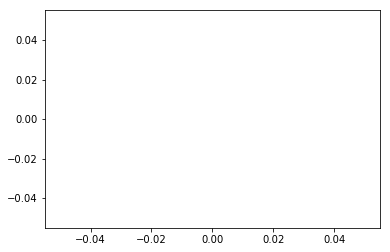

In [119]:
# MNIST - Reduced to 20 dims, PCA to 100 dims (?)
Plot.scatter(Y[:,0], Y[:,1], 20, label_sub_bw);
Plot.show();

In [120]:
Y

array([[ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       ..., 
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan]])

In [ ]:
%matplotlib inline
plt.imshow(img_arr.reshape(32,32))
X.shape

In [8]:
size = 28,28
n_pixels = size[0]*size[1]
data = []
labels = []
# Link to new extracted data
image_dir_root = r"\Color_LinearScale_Output"
for root, dirs, files in os.walk(image_dir_root):
    for file in files:
        peptide_name = file.split('_')[0]
        raw_image = PIL.Image.open(os.path.join(root, file))
        resized_image = raw_image.resize(size, PIL.Image.LANCZOS)
        flat_image = [(sum(sublist) / float(len(sublist))) for sublist in list(resized_image.getdata())]
        data.append(flat_image) 
        labels.append(peptide_dict_enumerated[peptide_name])
        
data = np.asarray(data)
labels = np.asarray(labels)

In [9]:
data.shape

(184656, 784)

In [69]:
X = Math.loadtxt("mnist2500_X.txt");
Y_labels = Math.loadtxt("mnist2500_labels.txt");

In [15]:
X.shape

(2500, 784)

In [34]:
a = np.arange(3920).reshape(5,784)

In [37]:
n1 = range(2)
n2 = range(784)

In [38]:
a.shape

(5, 784)

In [41]:
a[np.ix_(n1, n2)].shape

(2, 784)

In [43]:
subset_range = range(2500)
pixel_range = range(784)
data_sub = data[np.ix_(subset_range,pixel_range)]
label_sub = labels[np.ix_(subset_range)]

In [47]:
data_sub.shape

(2500, 784)

In [74]:
# Peptide data with numpy.ndarray -> data and labels
Y = tsne(temp_round, 2, 50, 20.0,10);

Computing pairwise distances...
Computing P-values for point 0 of 2500


c:\users\prashanth\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
c:\users\prashanth\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
c:\users\prashanth\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
c:\users\prashanth\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


Computing P-values for point 500 of 2500
Computing P-values for point 1000 of 2500
Computing P-values for point 1500 of 2500
Computing P-values for point 2000 of 2500
Mean value of sigma: 2.9669402313868747


c:\users\prashanth\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in maximum
c:\users\prashanth\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater
c:\users\prashanth\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in maximum


Iteration : 10 Error : nan


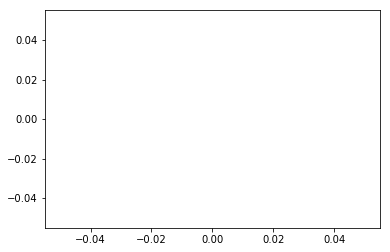

In [75]:
# MNIST - Reduced to 20 dims, PCA to 100 dims (?)
Plot.scatter(Y[:,0], Y[:,1], 20, label_sub);
Plot.show();

In [76]:
Y

array([[ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       ..., 
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan]])

In [53]:
np.round(data_sub)

array([[ 64.,  64.,  64., ...,  64.,  64.,  64.],
       [ 64.,  64.,  64., ...,  64.,  64.,  64.],
       [ 64.,  64.,  64., ...,  64.,  64.,  64.],
       ..., 
       [ 64.,  64.,  64., ...,  64.,  64.,  64.],
       [ 64.,  64.,  64., ...,  64.,  64.,  64.],
       [ 64.,  64.,  64., ...,  64.,  64.,  64.]])

In [72]:
temp_round = np.round(data_sub)
temp_round[temp_round == 64.0] = 1.0

In [73]:
temp_round

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [113]:
type(data_sub_bw[1][1])

numpy.ndarray

In [112]:
type(X[1][1])

numpy.float64

In [122]:
data_sub_bw[1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [121]:
X[1]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1